In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FuncFormatter
import glob
import os
import datetime as datetime 
import seaborn as sns
import re

In [262]:
def data_load(path):
    """
    Load data file.
    """
    df = pd.read_excel(path)
    # remove the last column
    # df = df.iloc[:, :-1]
    # Calculate the 'Age' of the vehicle
    return df


def service_year_calculate(df):
    """
    Calculate the service year of the vehicle.
    """
    df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
    df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
    df['service year'] =  (df['Retire date filled'] - df['Date Accepted']).dt.days/365
    df['service year'] = df['service year'].round(1)
    return  df['service year']


def get_retired_vehicle(df):
    """
    Get the retired data.
    """
    df['Date Actual Retire'] = pd.to_datetime(df['Date Actual Retire'], errors='coerce')
    df['Actual Replacement date'] = pd.to_datetime(df['Actual Replacement date'], errors='coerce')
    # filter out the 'Retired' vehicles that have no 'Retirement Date' and 'replacement date' at the same time
    results = df[df[['Date Actual Retire', 'Actual Replacement date']].notna().any(axis=1)]
    results['service year'] = service_year_calculate(results)
    return results


def total_vkt(df):
    """
    Calculate the total VKT of the vehicle.
    """
    df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
    df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
    df['num_days'] = (df['Retire date filled'] - df['Date Accepted']).dt.days
    df['Total VKT'] = 365 * df['Current Odometer Reading'] / df['num_days'] # annual equivalent vkt
    df['Total VKT'] = df['Total VKT'].round(0)
    return df['Total VKT']
# def activity_make_model_match(df):
#     activity_make_model_df = pd.DataFrame(columns=['Make', 'Model', 'Activity Type Description'])
#     for vehicle_type in df['Activity Type Description'].unique():
#         vehicle_df = df[df['Activity Type Description'] == vehicle_type]
#         make_model = vehicle_df[['Make', 'Model']].drop_duplicates()
#         make_model['Activity Type Description'] = vehicle_type
#         activity_make_model_df = pd.concat([activity_make_model_df, make_model], ignore_index=True)

#     # remove null values
#     activity_make_model_df = activity_make_model_df.dropna()
#     # sort the dataframe by 'Make' and 'Model'
#     activity_make_model_df = activity_make_model_df.sort_values(by=['Make', 'Model'])

#     return activity_make_model_df

In [317]:
data_dir_new = '../../data/Aramco Leased Vehicles - from 2012 up-to-01-30-2025 - Including VTK and Acceptance Date.xlsx'
data_dir_old = '../../data/Aramco Leased Vehicles - from 2012 up-to-date with make and model.xlsx'
fuel_type_path = '../../data/Aramco Leased Vehicles - from 2012 up-to-date with fueltype.xlsx'
df_new = data_load(data_dir_new)
df_old = data_load(data_dir_old)
fuel_type = data_load(fuel_type_path)
df_new['Fuel Type'] = ''
# Replace columns 'Make' and 'Model' with 'Make' and 'Model' from the old data
# Create mappings
colA_map = df_old.set_index('Vehicle Number')['Make']
colB_map = df_old.set_index('Vehicle Number')['Model']
# Replace only where match exists
df_new['Make'] = df_new['Vehicle Number'].map(colA_map).fillna(df_new['Make'])
df_new['Model'] = df_new['Vehicle Number'].map(colB_map).fillna(df_new['Model'])
df_new['Fuel Type'] = df_new['Vehicle Number'].map(fuel_type.set_index('Vehicle Number')['Fuel Type'])
df_new.loc[df_new['Fuel Type'].isna() | (df_new['Fuel Type'].str.strip() == ''), 'Fuel Type'] = 'Gasoline'
df_new['Today'] = pd.to_datetime(datetime.date(2025, 5, 1))

df_new.head()

,Primary Status Description,Tracking Unit IMEI,Vehicle Number,Make,Model,Model Year,Activity Type,Activity Type Description,Date Actual Retire,Actual Replacement date,Date Accepted,Current Odometer Reading,Vehicle Type,Fuel Type,Today
0,Retired,NaN,RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"160,282",SUV,Gasoline,2025-05-01
1,Retired,NaN,RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"86,302",SUV,Gasoline,2025-05-01
2,Retired,NaN,RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"166,570",SUV,Gasoline,2025-05-01
3,Retired,NaN,RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"11,023",SUV,Gasoline,2025-05-01
4,Retired,NaN,RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"135,688",SUV,Gasoline,2025-05-01


In [318]:
df_new['Vehicle Type'].unique()

array(['SUV', 'Sedan', 'Others', 'Light-duty truck', 'Security Patrol'],
      dtype=object)

In [319]:
print(df_new.shape, df_new['Activity Type Description'].nunique(), df_new.dtypes)
df_new.to_excel('../../data/fleet_data_merged_results.xlsx', index=False)

(25277, 15) 93 Primary Status Description            object
Tracking Unit IMEI                   float64
Vehicle Number                        object
Make                                  object
Model                                 object
Model Year                             int64
Activity Type                         object
Activity Type Description             object
Date Actual Retire            datetime64[ns]
Actual Replacement date       datetime64[ns]
Date Accepted                 datetime64[ns]
Current Odometer Reading              object
Vehicle Type                          object
Fuel Type                             object
Today                         datetime64[ns]
dtype: object


In [285]:
retired_vehicle_df = get_retired_vehicle(df_new)
print(retired_vehicle_df.shape)
retired_vehicle_df.head()
# num_total_vehicle_type = fleet_df['Activity Type Description'].nunique()
# num_retired_vehicle_type = retired_vehicle_df['Activity Type Description'].nunique()
# print(num_retired_vehicle_type, num_total_vehicle_type)
# # Get the vehicle types not in retired vehicles
# types_not_in_retired = fleet_df[~fleet_df['Activity Type Description'].isin(retired_vehicle_df['Activity Type Description'])]['Activity Type Description'].unique()
# print(types_not_in_retired) # ["D Van 12' Hyd. Tailg", 'Re-lamper Truck, 4x', 'Crane Truck 4X2, Die','Comm Emerg. Equip V']

(14110, 17)


/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/3737690349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/3737690349.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/3737690349.py:18: SettingWithC

,Primary Status Description,Tracking Unit IMEI,Vehicle Number,Make,Model,Model Year,Activity Type,Activity Type Description,Date Actual Retire,Actual Replacement date,Date Accepted,Current Odometer Reading,Vehicle Type,Fuel Type,Today,Retire date filled,service year
0,Retired,NaN,RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"160,282",SUV,Gasoline,2025-05-01,2013-03-31,0.7
1,Retired,NaN,RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"86,302",SUV,Gasoline,2025-05-01,2013-03-31,0.7
2,Retired,NaN,RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"166,570",SUV,Gasoline,2025-05-01,2013-03-31,0.7
3,Retired,NaN,RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"11,023",SUV,Gasoline,2025-05-01,2013-03-31,0.7
4,Retired,NaN,RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"135,688",SUV,Gasoline,2025-05-01,2013-03-31,0.7


In [ ]:
# activity_make_model_df = activity_make_model_match(retired_vehicle_df)
# activity_make_model_df.head()

,Make,Model,Activity Type Description
157,BMW,740Li,Sedan Executive (3)
158,BMW,750Li,Sedan Executive (3)
2,Cadillac,CT6,Sedan Executive (2)
177,Cadillac,Escalade,Executive Carryall
21,Chevy,Caprice,Sedan Full-Size


In [ ]:
# save the resulting dataframe to a new excel file
# output_path = '../../results/activity_make_model.xlsx'
# activity_make_model_df.to_excel(output_path, index=False)

In [ ]:
# # There are only 80 types here rather than 89 because we dropped the null makes and models
# activity_make_model_df['Activity Type Description'].nunique()
# activity_make_model_df.head()

,Make,Model,Activity Type Description
157,BMW,740Li,Sedan Executive (3)
158,BMW,750Li,Sedan Executive (3)
2,Cadillac,CT6,Sedan Executive (2)
177,Cadillac,Escalade,Executive Carryall
21,Chevy,Caprice,Sedan Full-Size


In [ ]:
# # Classify vehicles based on make, model, and activity type, join the two dataframes: vehicle_type_df and retired_vehicle_df
# # use inner_join here
# def classify_vehicle_type(vehicle_type_df, retired_vehicle_df):
#     df = vehicle_type_df.iloc[:, :-2]
#     df = df.drop(columns=['Vehicle Type', 'Renamed_type'], axis=1)
#     # join the two dataframes
#     df1 = pd.merge(retired_vehicle_df, df, on=['Make', 'Model', 'Activity Type Description'], how='inner')

#     return df1


# # The number of unique vehicle types here is 84 which is more than the number of unique vehicle types in the activity_make_model_df because we add those 4 which are not included in the retired vehicles
# data_path = '../../results/activity_make_model.xlsx'
# vehicle_type_df = pd.read_excel(data_path)
# vehicle_type_df.head()
# # merge_df = classify_vehicle_type(vehicle_type_df, retired_vehicle_df)
# # print(merge_df['Activity Type Description'].nunique())

,Make,Model,Activity Type Description
0,BMW,740Li,Sedan Executive (3)
1,BMW,750Li,Sedan Executive (3)
2,Cadillac,CT6,Sedan Executive (2)
3,Cadillac,Escalade,Executive Carryall
4,Chevy,Caprice,Sedan Full-Size


In [282]:
# merge activity_make_model matched data with the raw fleet data to check how many vehicles are in each type
# raw_fleet_merge_activity_make_model = classify_vehicle_type(vehicle_type_df, fleet_df)
# check the number of unique vehicle types
# hdt = df_new[df_new['Suggested_Classification']=='heavy-duty truck'].shape[0]
mdt_g = df_new[(df_new['Vehicle Type']=='Others') & (df_new['Fuel Type']=='Gasoline')].shape[0]
mdt_d = df_new[(df_new['Vehicle Type']=='Others') & (df_new['Fuel Type']=='Diesel')].shape[0]
ldt_g = df_new[(df_new['Vehicle Type']=='Light-duty truck') & (df_new['Fuel Type']=='Gasoline')].shape[0]
ldt_d = df_new[(df_new['Vehicle Type']=='Light-duty truck') & (df_new['Fuel Type']=='Diesel')].shape[0]
# bus_g = df_new[(df_new['Vehicle Type']=='Bus') & (df_new['Fuel Type']=='Gasoline')].shape[0]
# bus_d = df_new[(df_new['Vehicle Type']=='Bus') & (df_new['Fuel Type']=='Diesel')].shape[0]
sedan_g = df_new[(df_new['Vehicle Type']=='Sedan') & (df_new['Fuel Type']=='Gasoline')].shape[0]
sedan_d = df_new[(df_new['Vehicle Type']=='Sedan') & (df_new['Fuel Type']=='Diesel')].shape[0]
suv_g = df_new[(df_new['Vehicle Type']=='SUV') & (df_new['Fuel Type']=='Gasoline')].shape[0]
suv_d = df_new[(df_new['Vehicle Type']=='SUV') & (df_new['Fuel Type']=='Diesel')].shape[0]
sec_g = df_new[(df_new['Vehicle Type']=='Security Patrol') & (df_new['Fuel Type']=='Gasoline')].shape[0]
sec_d = df_new[(df_new['Vehicle Type']=='Security Patrol') & (df_new['Fuel Type']=='Diesel')].shape[0]
# van = df_new[df_new['Suggested_Classification']=='van'].shape[0]
total = mdt_g + mdt_d + ldt_g + ldt_d  + sedan_g + sedan_d + suv_g + suv_d + sec_g + sec_d
print(mdt_g, mdt_d, ldt_g, ldt_d, sedan_g, sedan_d, suv_g, suv_d, sec_g, sec_d, total, df_new.shape[0])

2226 276 7259 77 7859 0 6905 26 642 7 25277 25277


In [ ]:
# print(retired_vehicle_df.shape, merge_df.shape)
# merge_df.head()
# merge_df.to_csv('../../results/merged_vehicle_type.csv', index=False)

(13133, 11) (13079, 13)


In [286]:
# Calculate survival rate by vehicle type
def calculate_survival_pattern(df):
    vehicle_types = df['Vehicle Type'].unique()
    survival_rate = {}

    for veh_type in vehicle_types:
        num_vehicles = len(df[df['Vehicle Type'] == veh_type])
        survival_rate[veh_type] = []
        df['service year rounded'] = df['service year'].round()
        num_retired = 0
        max_age = df.loc[df['Vehicle Type'] == veh_type, 'service year rounded'].max()
        vehicle_age = range(int(df.loc[df['Vehicle Type'] == veh_type, 'service year rounded'].max()) + 1)
        for age in vehicle_age:
            num_retired += len(df[(df['Vehicle Type'] == veh_type) & (df['service year rounded'] == age)])
            try:
                survival_rate[veh_type].append((num_vehicles - num_retired)/num_vehicles)
            except ZeroDivisionError:
                survival_rate[veh_type].append(0) 
                print(f"❌ Failed to fetch website: {veh_type} at age {age}")

    survival_rate_df = pd.DataFrame.from_dict(survival_rate, orient='index').fillna(0)
    survival_rate_df.head()

    return survival_rate_df


survival_df = calculate_survival_pattern(retired_vehicle_df)

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/1764354595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['service year rounded'] = df['service year'].round()


In [287]:
survival_df.head()
# survival_df.to_csv('../../results/survival_rate1.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
SUV,0.987785,0.966341,0.928339,0.890065,0.807003,0.687839,0.578447,0.445983,0.182139,0.067590,0.035559,0.002986,0.000000,0.000000,0.000000,0.000000,0.0
Sedan,0.988275,0.978579,0.962570,0.925592,0.800676,0.620744,0.460428,0.341150,0.059752,0.003382,0.000225,0.000225,0.000000,0.000000,0.000000,0.000000,0.0
Others,0.996508,0.990922,0.981844,0.935056,0.867318,0.659218,0.501397,0.430866,0.246508,0.203212,0.120112,0.026536,0.000000,0.000000,0.000000,0.000000,0.0
Light-duty truck,0.995114,0.991204,0.986807,0.979233,0.937210,0.815050,0.569265,0.519668,0.401417,0.309309,0.142927,0.007574,0.000000,0.000000,0.000000,0.000000,0.0
Security Patrol,1.000000,0.987124,0.967811,0.901288,0.478541,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.002146,0.0


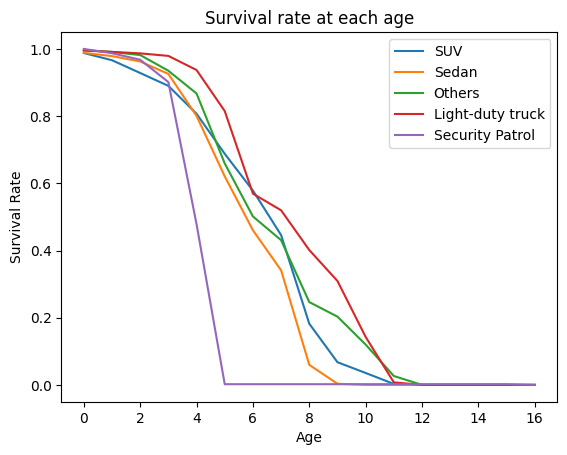

In [288]:
# Visualize the survival rate
for index, row in survival_df.iterrows():
    plt.plot(row, label=index)

plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.title('Survival rate at each age')
plt.legend()
plt.show()

In [289]:
df_new['service year'] = service_year_calculate(df_new)
df_new['Current Odometer Reading'] = df_new['Current Odometer Reading'].str.replace(",", "")
df_new['Current Odometer Reading'] = pd.to_numeric(df_new['Current Odometer Reading'], errors='coerce').astype('Int64')
df_new['Total VKT'] = total_vkt(df_new)

In [213]:
df_new['Current Odometer Reading']

0        160282
1         86302
2        166570
3         11023
4        135688
          ...  
25272      7339
25273      2175
25274      1610
25275     12100
25276      2346
Name: Current Odometer Reading, Length: 25277, dtype: Int64

In [315]:
######################################################################################    
# def vkt_dist_visualization(df):

#     def sci_formatter(x, pos):
#         return f"$10^{int(x)}$" if x >= 1 else ""
    
#     vehicle_class = df['Vehicle Type'].unique()
#     class_list = []
#     palette = sns.color_palette("tab10", len(vehicle_class))
#     fig, ax = plt.subplots()
#     for i, vehicle_cls in enumerate(vehicle_class):
#         vkt = df[df['Vehicle Type']==vehicle_cls]['Total VKT'].dropna() 
#         sns.histplot(np.log10(vkt.values), stat='percent', kde=True, ax=ax, 
#             label=vehicle_cls,
#             color=palette[i],
#             alpha=0.6,
#             linewidth=1.5)
#         class_list.append(vehicle_cls)
#     ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
#     plt.xlabel('Total VKT (km)')
#     plt.ylabel('Percent')
#     plt.title(f'VKT distribution')
#     plt.legend(class_list)

def vkt_dist_visualization_subplots(df):
    def sci_formatter(x, pos):
        return f"$10^{{{int(x)}}}$" if x >= 1 else ""

    vehicle_classes = df['Vehicle Type'].unique().tolist()
    if "Bus" in vehicle_classes:
        vehicle_classes.remove("Bus")
    n = len(vehicle_classes)

    # Remove inf and NaN from 'Total VKT'
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=['Total VKT'])

    # Set up subplots: 1 column, n rows
    ncols = 1
    nrows = n
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4*nrows), squeeze=False)

    palette = sns.color_palette("tab10", n)

    for i, vehicle_cls in enumerate(vehicle_classes):
        ax = axes[i, 0]

        vkt = df[df['Vehicle Type'] == vehicle_cls]['Total VKT']
        if len(vkt) == 0:
            ax.axis('off')
            continue

        log_vkt = np.log10(vkt.values)
        mean_vkt = np.mean(vkt.values)

        # Plot histogram and capture bar heights
        hist_data = sns.histplot(log_vkt, stat='percent', kde=False, bins=30,
                                 alpha=0.6, color=palette[i], ax=ax, linewidth=0)
        
        # Get histogram peak height
        bar_heights = [bar.get_height() for bar in hist_data.patches]
        max_bar_height = max(bar_heights) if bar_heights else 1

        # Plot KDE
        kde_plot = sns.kdeplot(log_vkt, ax=ax, color=palette[i], linewidth=2)
        line = kde_plot.get_lines()[-1]
        y_kde = line.get_ydata()
        max_kde_height = y_kde.max() if len(y_kde) > 0 else 1

        # Scale KDE to match histogram peak
        scale_factor = max_bar_height / max_kde_height
        line.set_ydata(y_kde * scale_factor)

        # Add mean VKT label
        ax.text(0.95, 0.90,
                f"Mean VKT: {mean_vkt:,.0f} km",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=18, color='black')

        ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
        ax.set_xlabel('Total VKT (km, log10 scale)', fontsize=18)
        ax.set_ylabel('Percent (%)', fontsize=18)
        ax.set_title(f'VKT Distribution: {vehicle_cls}', fontsize=20)
        ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


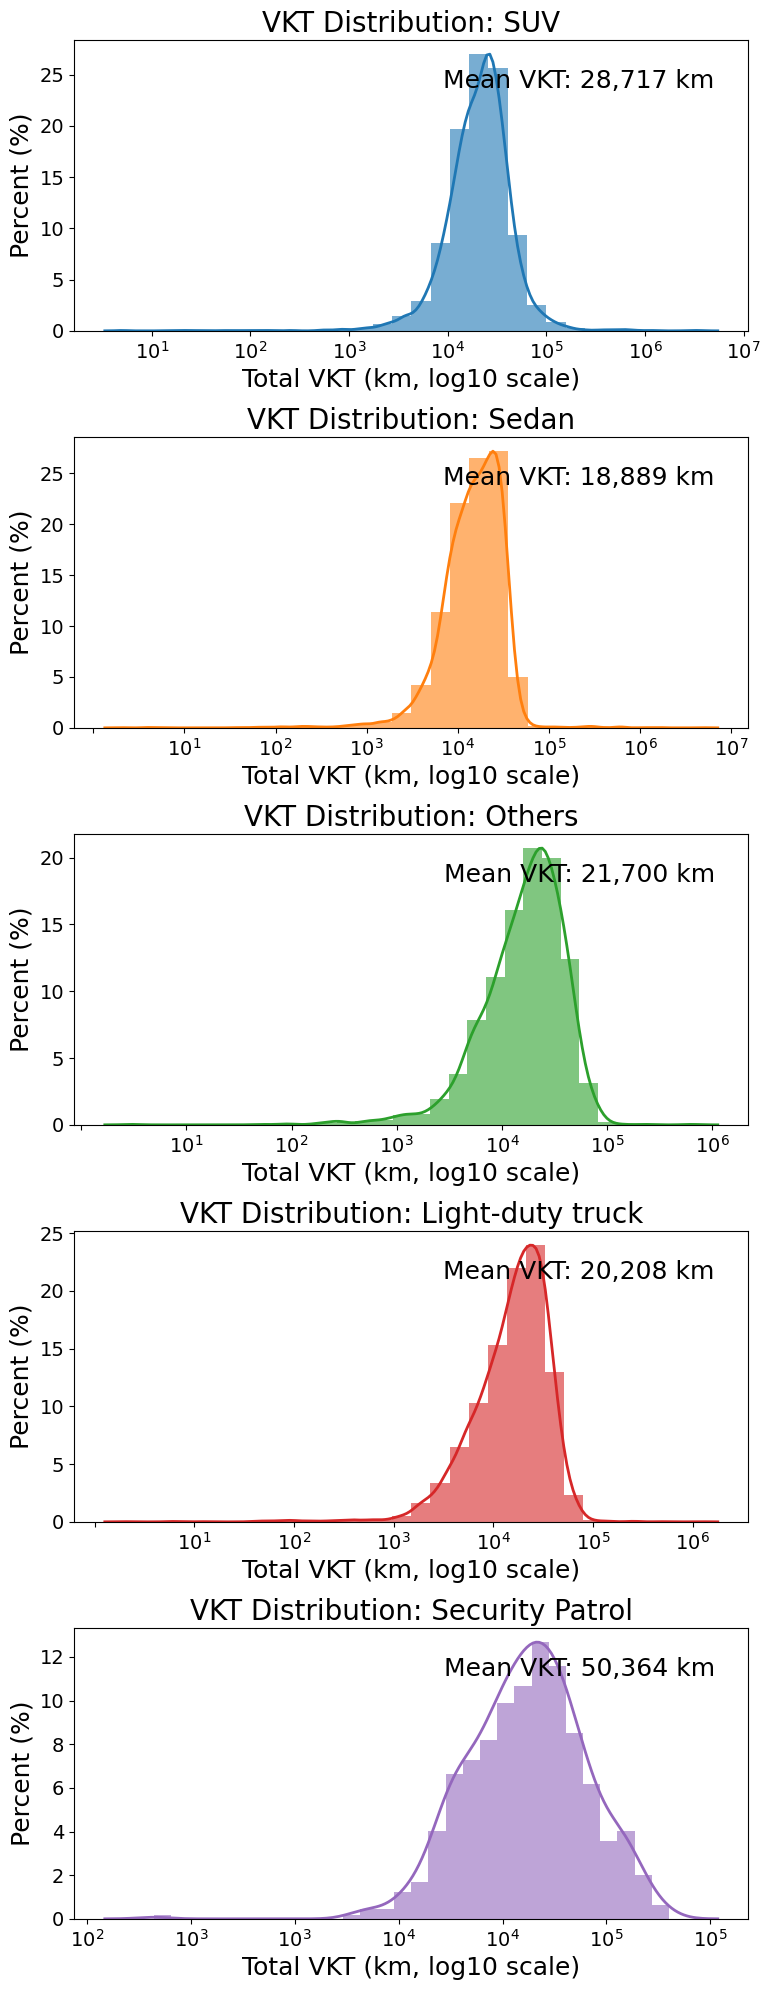

In [316]:
vkt_dist_visualization_subplots(df_new)
# vkt_distribution.to_csv(f'../../results/vkt_distribution_{year}.csv', index=False)
# Still need to convert the actual recorded vkt of each vehicle (for those cut in or step out during the year) to annual equaivalent vkt

In [294]:
df_new['Total VKT'] = df_new['Total VKT'].replace([np.inf, -np.inf], np.nan).dropna()
print(df_new[df_new['Vehicle Type'] == 'Others']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'Light-duty truck']['Total VKT'].mean(), 
      df_new[df_new['Vehicle Type'] == 'Security Patrol']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'Sedan']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'SUV']['Total VKT'].mean())


21699.50820985182 20207.75263807044 50363.59350850077 18888.783998972645 28716.557111913356
